- By: Alex Kwon
- Email: alex.kwon [at] hudsonthames [dot] org

# Statistical Arbitrage - Pairs Trading

## Abstract

Statistical Arbitrage exploits the pricing inefficiency between two groups of assets. First developed and used in the mid-1980s by Nunzio Tartaglia’s quantitative group at Morgan Stanley, the classical strategy utilizes systematic trading signals and a market-neutral approach to generate positive returns.

The strategy can be explained in a two-step process. First, two baskets of assets that have historically moved similarly are identified. Then, the spread between the two is carefully measured to look for signals of divergence. If the spread becomes wider than the value suggested by historical data, the trader longs the losing basket and shorts the winning one. As the spread reverts back to the mean, the positions will gain in value.

## Introduction

Most strategies involving statistical arbitrage can be expressed with the following equation:

$\frac{dP_t}{P_t} = \alpha dt + \beta \frac{dQ_t}{Q_t} + dX_t$

- $P_t$: Price of the first group of assets.

- $Q_t$: Price of the second group of assets.

- $\alpha$: Drift term. For the most parts, we will assume that this value is 0.

- $\beta$: Regression coefficient between the change in returns.

- $X_t$: Cointegration residual.

We can interpret this in two different ways.

1. If $X_t$ is a significant positive value, we will long 1 unit of $P_t$ and short $\beta$ unit of $Q_t$.

2. If $X_t$ is a significant negative value, we will short 1 unit of $P_t$ and long $\beta$ unit of $Q_t$.

$X_t$ will be described much more in detail in the section for ``signals``.

We can, therefore, interpret statistical arbitrage as a contrarian strategy to harness the
mean-reverting behavior of the pair ratio to exploit the mispricing of the assets.

## Strategies

This module currently employs two different statistical arbitrage strategies.

1. Pairs Trading
2. Eigenportfolio

## Signals

There are many methods to implement statistical arbitrage, and thorough investigation for each procedure is needed before applying these tools to a real live trading environment.

We have provided 3 possible signals to long/short our assets of interest.

1. S-Score from Ornstein-Uhlenbeck Process
2. Mean Reversion Time from Ornstein-Uhlenbeck Process
3. Z-Score from a Gaussian Distribution

### Ornstein-Uhlenbeck Process

The Ornstein-Uhlenbeck process is a stochastic mean-reverting process with the following equation:

$dX_t = \kappa(m − X_t)dt + \sigma dW_t$

- $X_t$: Residual from the spread.
- $\kappa$: Rate of mean reversion.
- $m$: Mean of the process.
- $\sigma$: Variance or volatility of the process.
- $W_t$: Wiener process or Brownian motion.

This can be changed into an $AR(1)$ model with the following properties:

$X_{n+1} = a + b X_n + \zeta_{n+1}$

- $b = e^{-\kappa \Delta_t}$
- $a = m(1 - b)$
- $var(\zeta) = \sigma^2 \frac{1 - b^2}{2 \kappa}$

We will primarily use the OU-process to generate trading signals for statistical arbitrage.
The trading signals will be defined as:

$s = \frac{X_t - E(X_t)}{var(X_t)} = \frac{m\sqrt{2\kappa}}{\sigma}$

## Z-Score

Z-Score is also another popular method of measuring the distance of the measurement from the mean.
It has an underlying assumption that the distribution is Gaussian, which may not necessarily be
true for many of the financial data available to us. Nonetheless, it is often used as the simple
but powerful equation indicates the magnitude of the deviation from the mean.

$z = \frac{x - \mu}{\sigma}$

- $x$: Data point
- $\mu$: Mean
- $\sigma$: Standard Deviation

## Pairs Trading

Pairs trading strategy is a specific statistical arbitrage strategy that focuses on two assets. Pairs trading harnesses the pricing inefficiency caused by the widening spread of two assets. Generally, pairs trading strategies can be implemented in three parts.

1. Filter the universe to select a number of pairs. These pairs are two related securities, which are oftentimes in the same sector/industry and have similar fundamental values.

2. Calculate the spread between the two pairs and test for stationarity and cointegration.

3. If all the tests are satisfied, generate trading signals to long the asset that is underpriced and short the other.

We will try pairs trading with a very well known example of ``Coca-Cola`` and ``Pepsi``

### Import Packages

In [21]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import plotly
plotly.io.renderers.default = "svg" # Toggle for GitHub rendering

from mlfinlab.statistical_arbitrage import *

### Import Data

In [22]:
data = yf.download(['KO','PEP'])['Adj Close'].dropna()

[*********************100%***********************]  2 of 2 completed


In [23]:
data

,KO,PEP
Date,,
1972-06-01,0.027130,0.443978
1972-06-02,0.027028,0.442695
1972-06-05,0.026976,0.437547
1972-06-06,0.026745,0.433687
1972-06-07,0.026617,0.431113
...,...,...
2020-06-17,46.580002,131.759995
2020-06-18,46.990002,132.779999
2020-06-19,46.020000,131.279999


### Initial Analysis

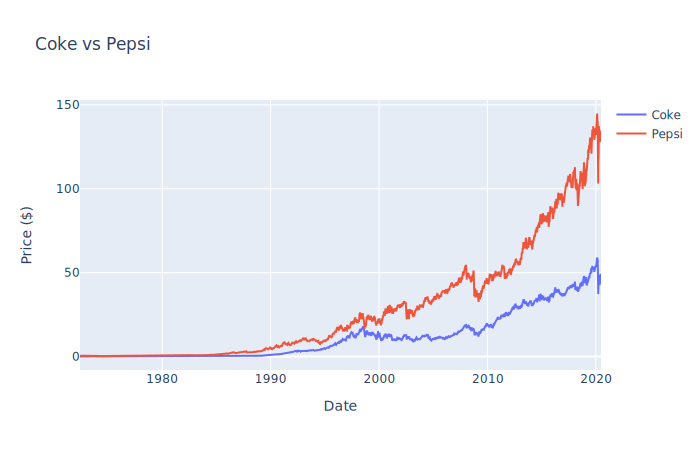

In [24]:
fig = go.Figure()
idx = data.index
fig.add_trace(go.Scatter(x=idx, y=data['KO'], name='Coke'))
fig.add_trace(go.Scatter(x=idx, y=data['PEP'], name='Pepsi'))
fig.update_layout(title='Coke vs Pepsi', xaxis_title='Date', yaxis_title='Price ($)')
fig.show()

Pepsi has performed much better than Coke in the last 2 decades, but in general, we see a correlation between the two as they move in similar directions.

### StatArb Class

We created a general class called ``StatArb`` to create a general pairs trading strategy framework. This parent class will allow us to quickly implement and modularize the various ways of identifying the trading assets and seeking different hedge ratios to capture the idiosyncratic risk.

In [25]:
# Initiate pairs trading class.
model = StatArb()

In [26]:
# Coke as X and Pepsi as Y with no rollowing window and intercept=True.
model.allocate(data['KO'], data['PEP'])

### Log Returns

``model.log_returns`` is used to call the log-returns of the original data.

In [27]:
model.log_returns

,KO,PEP
Date,,
1972-06-01,0.000000,0.000000
1972-06-02,-0.003787,-0.002895
1972-06-05,-0.001899,-0.011696
1972-06-06,-0.008591,-0.008863
1972-06-07,-0.004806,-0.005952
...,...,...
2020-06-17,-0.004071,0.000683
2020-06-18,0.008764,0.007712
2020-06-19,-0.020859,-0.011361


### Beta
``model.beta`` is used to call beta, the hedge ratio, of the given data.

In [28]:
model.beta

,beta,constant
0,0.501693,0.000162


We can interpret this as returns for Pepsi can be modeled as 0.501714 of returns of Coke + 0.000162. In an equation form:

$R_{PEP} = 0.501714 * R_{KO} + 0.0001624$

In [29]:
t = pd.DataFrame(np.linspace(-0.3, 0.2, 1000).reshape((1000, 1)), columns=['x'])
t['y'] = t * model.beta.iloc[0, 0] + model.beta.iloc[0, 1]

In [30]:
fig = go.Figure(layout=go.Layout(title='Regression on Returns', xaxis_title='KO Log Returns', yaxis_title='PEP Log Returns'))
fig.add_trace(go.Scatter(x=model.log_returns['KO'], y=model.log_returns['PEP'], mode='markers', name='Data'))
fig.add_trace(go.Scatter(x=t['x'], y=t['y'], mode='lines', name='Reg. Line'))
fig.show()

It's certainly not the best regression line, but we can somewhat see a correlation of the two popular company's returns.

### Residuals

``model.resid`` is used to call the residuals of the regression model.

In [31]:
model.resid

,Residuals
Date,
1972-06-01,-0.000162
1972-06-02,-0.001156
1972-06-05,-0.010905
1972-06-06,-0.004714
1972-06-07,-0.003702
...,...
2020-06-17,0.002564
2020-06-18,0.003153
2020-06-19,-0.001058


This represents how much the returns deviated from the regression model each day.

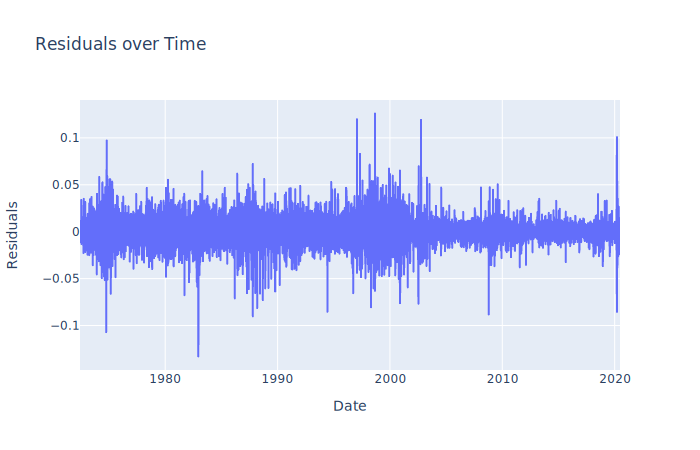

In [32]:
fig = px.line(model.resid, x=model.resid.index, y="Residuals", title='Residuals over Time')
fig.show()

### Cumulative Residuals

``model.cum_resid`` is used to call the cumulative residuals of the regression model.

In [33]:
model.resid

,Residuals
Date,
1972-06-01,-0.000162
1972-06-02,-0.001156
1972-06-05,-0.010905
1972-06-06,-0.004714
1972-06-07,-0.003702
...,...
2020-06-17,0.002564
2020-06-18,0.003153
2020-06-19,-0.001058


The cumulative residuals represent the additive price difference between Coke and Pepsi, which indicates how distant the current prices are from the original price relation equation.


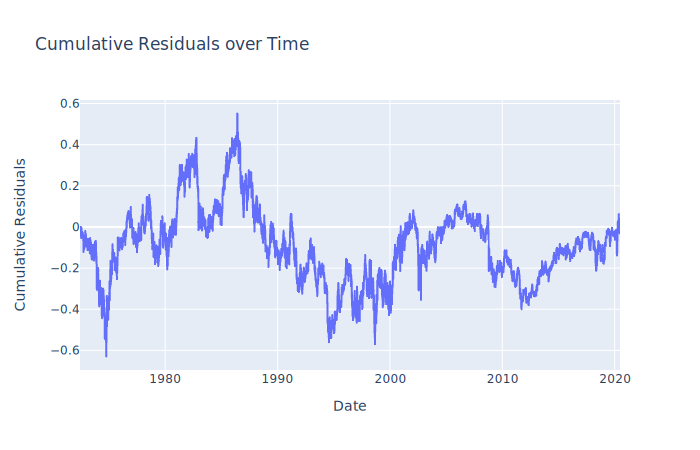

In [34]:
fig = px.line(model.cum_resid, x=model.cum_resid.index, y="Cumulative Residuals", title='Cumulative Residuals over Time')
fig.show()

We notice that the cumulative residuals start at 0 and end at 0. This is a result from running a regression on the entire data set.

In [35]:
calc_adfuller(model.cum_resid)

(-3.1727105406573464,
 0.021619645068998092,
 9,
 12111,
 {'1%': -3.430890061642661,
  '5%': -2.861778679702132,
  '10%': -2.56689704416959},
 -69834.21405930522)

### Z-Score

``model.z_score`` is used to call the z_score of the cumulative residuals of the regression model.

In [36]:
model.z_score

,Z-Score
Date,
1972-06-01,0.506206
1972-06-02,0.499829
1972-06-05,0.439690
1972-06-06,0.413691
1972-06-07,0.393273
...,...
2020-06-17,0.471035
2020-06-18,0.488423
2020-06-19,0.482586


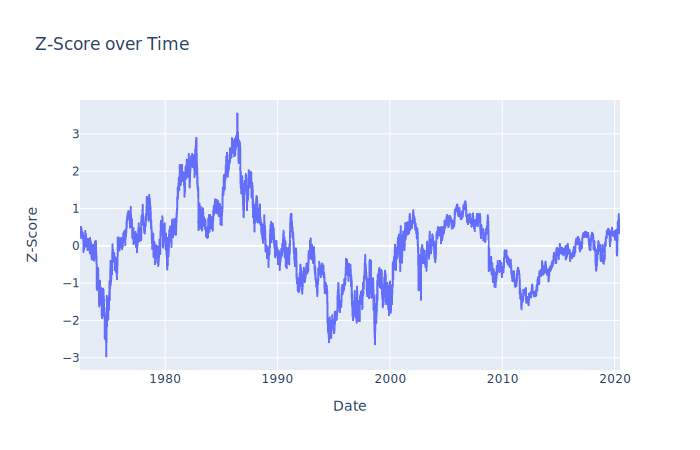

In [37]:
fig = px.line(model.z_score, x=model.z_score.index, y="Z-Score", title='Z-Score over Time')
fig.show()

Traditional methods for z-score signals include:

- At z-score of 2, long 1 of price_x and short $\beta$ of price_y
- At z-score of 1, close out your trades.
- At z-score of -2, short 1 of price_x and long $\beta$ of price_y
- At z-score of -1, close out your trades.

We will examine different trading signals soon.

### S-Score

``model.s_score`` is used to call the s_score of the cumulative residuals of the regression model calculated from the Ornstein-Uhlenbeck Process. 

In [38]:
model.s_score

,S-Score
Date,
1972-06-01,0.506203
1972-06-02,0.499826
1972-06-05,0.439689
1972-06-06,0.413690
1972-06-07,0.393273
...,...
2020-06-17,0.471033
2020-06-18,0.488420
2020-06-19,0.482583


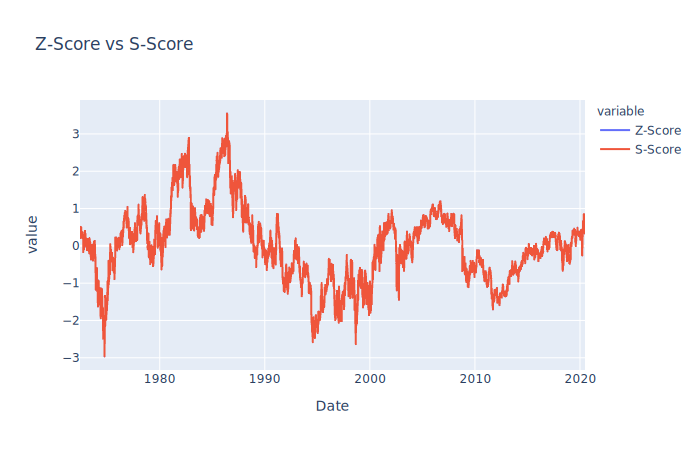

In [39]:
z_s_score = pd.concat([model.z_score, model.s_score], axis=1)
fig = px.line(z_s_score, x=model.cum_resid.index, y=z_s_score.columns, title='Z-Score vs S-Score')
fig.show()

Z-Score and S-Score tend to be the same if it is calculated for a long duration of time.

### Mean Reversion Time

``model.mr_time`` is used to call the mean reversion time of the cumulative residuals of the regression model calculated from the Ornstein-Uhlenbeck Process.

In [40]:
model.mr_time

,Mean Reversion Time
Date,
1972-06-01,1.433077
1972-06-02,1.433077
1972-06-05,1.433077
1972-06-06,1.433077
1972-06-07,1.433077
...,...
2020-06-17,1.433077
2020-06-18,1.433077
2020-06-19,1.433077


Because we calculated the regression over the entire dataset, there is only one mean reversion time. This will change if we are rolling over different windows.

## Signals and Backtesting with Z-Score

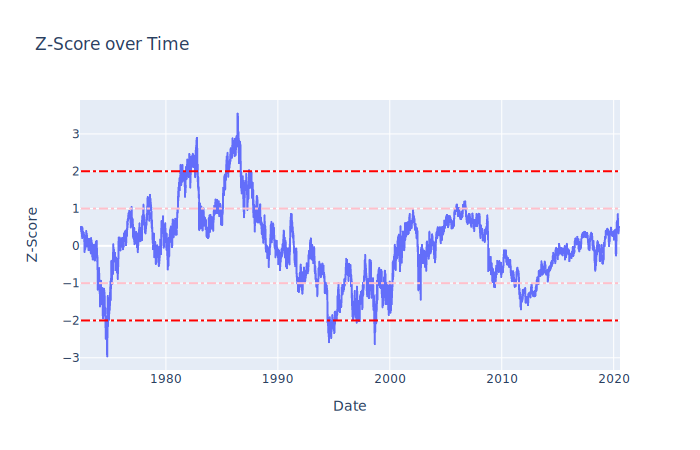

In [61]:
fig = px.line(model.z_score, x=model.z_score.index, y="Z-Score", title='Z-Score over Time')
fig.add_shape(type="line",x0=model.z_score.index[0],y0=-1,x1=model.z_score.index[-1],y1=-1,line=dict(color="Pink",width=2,dash="dashdot",),)
fig.add_shape(type="line",x0=model.z_score.index[0],y0=1,x1=model.z_score.index[-1],y1=1,line=dict(color="Pink",width=2,dash="dashdot",),)
fig.add_shape(type="line",x0=model.z_score.index[0],y0=-2,x1=model.z_score.index[-1],y1=-2,line=dict(color="Red",width=2,dash="dashdot",),)
fig.add_shape(type="line",x0=model.z_score.index[0],y0=2,x1=model.z_score.index[-1],y1=2,line=dict(color="Red",width=2,dash="dashdot",),)
fig.show()

In [64]:
z_score = model.z_score.copy()

### Mini-Trading Script

In [ ]:
# Thresholds for Trades.
enter = 2
exit = 1
z_score

In [309]:
def identify_signal_points(enter, exit, data):
    """
    Identify the data points that crosses the designated threshold for signal detection.
    
    :param enter: (float) Threshold to enter trade.
    :param exit: (float) Threshold to exit trade.
    :param data: (pd.DataFrame) Data for signal analysis.
    :return: (tuple) (list) enter_short_x, exit_short_x, enter_long_x, exit_long_x
    """
    # Store time index for each trade positions
    enter_short_x = []
    exit_short_x = []
    enter_long_x = []
    exit_long_x = []

    # 1 for Long X, -1 for Short X, 0 for Beginning.
    pos = 0 
    curr = data.iloc[0][0]

    for i in range(1, data.shape[0]):
        # Set prev and curr to reduce computation and look-up.
        prev = curr
        curr = data.iloc[i][0]

        # No trades opened.
        if pos == 0:
            # Enter long x. -1.9 -> -2.1.
            if (prev > -enter and curr < -enter):
                enter_short_x.append(i)
                pos = -1
            # Enter short x. 1.9 -> 2.
            elif (prev < enter and curr > enter):
                enter_long_x.append(i)
                pos = 1
        elif pos == 1:
            # Exit long x. -1.1 -> -0.9
            if (prev > exit and curr < exit):
                exit_long_x.append(i)
                # Neutral position
                pos = 0
        elif pos == -1:
            # Exit short x. 1.1 -> 0.9
            if (prev < -exit and curr > -exit):
                exit_short_x.append(i)
                # Neutral position
                pos = 0

    return enter_short_x, exit_short_x, enter_long_x, exit_long_x

In [311]:
enter_short_x, exit_short_x, enter_long_x, exit_long_x = identify_signal_points(2, 1, z_score)

In [312]:
def union_pos(enter_short_x, exit_short_x, enter_long_x, exit_long_x):
    """
    Create a union of entering position and exiting position for analysis later.
    
    :param enter_short_x: (list) Time index for entering short position.
    :param exit_short_x: (list) Time index for exiting short position.
    :param enter_long_x: (list) Time index for entering long position.
    :param exit_long_x: (list) Time index for exiting long position.
    :return: (tuple) enter_pos, exit_pos
    """
    # Union of entering positions.
    enter_pos = list(set().union(enter_short_x, enter_long_x))
    enter_pos.sort(reverse=False)

    # Union of exiting positions.
    exit_pos = list(set().union(exit_short_x, exit_long_x))
    exit_pos.sort(reverse=False)
    
    return enter_pos, exit_pos

In [314]:
enter_pos, exit_pos = union_pos(enter_short_x, exit_short_x, enter_long_x, exit_long_x)

In [319]:
def graph_signal_points(enter, exit, enter_short_x, exit_short_x, enter_long_x, exit_long_x, data):
    # Name of column.
    col = data.columns.item()
    first, last = data.index[0], data.index[-1]
    
    # Dashed lines.
    fig = px.line(data, x=data.index, y=col, title='Trading periods')
    fig.add_shape(type="line", x0=first, y0=-exit, x1=last, y1=-exit,line=dict(color="Pink",width=2,dash="dashdot",),)
    fig.add_shape(type="line", x0=first, y0=exit, x1=last, y1=exit,line=dict(color="Pink",width=2,dash="dashdot",),)
    fig.add_shape(type="line", x0=first, y0=-enter, x1=last, y1=-enter,line=dict(color="Pink",width=2,dash="dashdot",),)
    fig.add_shape(type="line", x0=first, y0=enter, x1=last, y1=enter,line=dict(color="Pink",width=2,dash="dashdot",),)
    
    # Graph each points.
    fig.add_trace(go.Scatter(x=data.iloc[enter_short_x].index, y=data.iloc[enter_short_x][col], mode='markers', marker={'size':10, 'color':'Green'}, name='Ent Sh X'))
    fig.add_trace(go.Scatter(x=data.iloc[enter_long_x].index, y=data.iloc[enter_long_x][col], mode='markers', marker={'size':10, 'color':'Green'}, name='Ent L X'))
    fig.add_trace(go.Scatter(x=data.iloc[exit_short_x].index, y=data.iloc[exit_short_x][col], mode='markers', marker={'size':10, 'color':'Red'}, name='Ex Sh X'))
    fig.add_trace(go.Scatter(x=data.iloc[exit_long_x].index, y=data.iloc[exit_long_x][col], mode='markers', marker={'size':10, 'color':'Red'}, name='Ex L X'))
    fig.show()

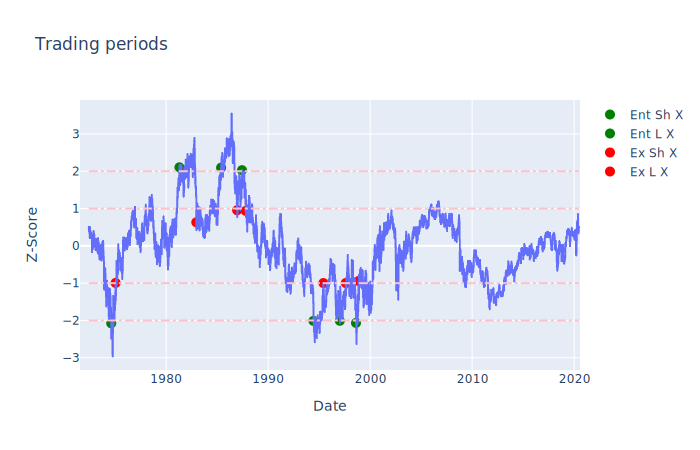

In [320]:
graph_signal_points(2, 1, enter_short_x, exit_short_x, enter_long_x, exit_long_x, model.z_score)

### Dollar Neutral Strategy

We used returns to calculate our regression. Our hedge ratio beta is therefore a dollar neutral strategy.

For \\$1 of change in x, there will be \\$0.501693  of change in y.

In [248]:
model.beta

,beta,constant
0,0.501693,0.000162


If we start out with a capital of 100,000. We will then split them into a ratio of $1:\beta$, which is $1:0.501693$.

In [249]:
capital = 100000
beta_ = model.beta.iloc[0, 0]

def convert_capital(capital, beta_, name_x, name_y):
    capital_x = capital / (1 + beta_)
    capital_y = capital * beta_ / (1 + beta_)
    return pd.DataFrame(np.array([[capital_x, capital_y]]), index=['Capital'], columns=[name_x, name_y])

allocation = convert_capital(capital, beta_, 'KO', 'PEP')
allocation

,KO,PEP
Capital,66591.50657,33408.49343


### First Trade: Short X, ``KO``

Let's examine the first trade, it happened around 1975. We first went 1 unit short on x, ``KO``, and $\beta$ unit long on y, ``PEP``.

In [250]:
enter_short_x[0], exit_short_x[0]

(553, 661)

In [251]:
model.log_returns.iloc[enter_short_x[0]:exit_short_x[0]]

,KO,PEP
Date,,
1974-08-13,-0.026879,-0.065063
1974-08-14,0.009569,-0.040006
1974-08-15,0.000000,-0.014684
1974-08-16,0.006329,-0.011905
1974-08-19,-0.001578,0.011905
...,...,...
1975-01-09,0.076099,0.028739
1975-01-10,0.025534,0.000000
1975-01-13,-0.034191,0.038893


In [252]:
first_trade = np.exp(model.log_returns.iloc[enter_short_x[0]:exit_short_x[0]].sum())
first_trade

KO     0.753081
PEP    0.980670
dtype: float64

In [253]:
def short(capital, trade_result):
    change = np.array([2, 0]) + np.array([-1, 1]) * trade_result
    return np.sum(capital * change).sum()

In [254]:
capital = short(allocation, first_trade)
capital

115796.93603335018

We got 15.796% increase from this trade.

### Second Trade: Long X, ``KO``

Let's examine the second trade, it happened around 1982 to 1984. We long 1 unit of x, ``KO``, and short $\beta$ unit of y, ``PEP``.

In [255]:
allocation = convert_capital(capital, beta_, 'KO', 'PEP')
allocation

,KO,PEP
Capital,77110.924267,38686.011766


In [256]:
enter_long_x[0], exit_long_x[0]

(2241, 2660)

In [257]:
second_trade = np.exp(model.log_returns.iloc[enter_long_x[0]:exit_long_x[0]].sum())
second_trade

KO     1.620877
PEP    1.232838
dtype: float64

In [258]:
def long(capital, trade_result):
    change = np.array([0, 2]) + np.array([1, -1]) * trade_result
    return np.sum(capital * change).sum()

In [259]:
capital = long(allocation, second_trade)
capital

154665.75195567982

In [260]:
capital/115796.93603335018

1.3356635957201424

We get 33.566% increase from this trade.

### Remaining Trades

Start with Capital --> Allocate to ``KO`` or ``PEP`` --> Calculate returns --> Adjust Capital --> Next Trade

In [321]:
# Check if number of trades is odd. If odd, the last trade might be still open and cause problems.
len(enter_pos) + len(exit_pos)

14

In [408]:
def calc_trade_returns(model, capital, enter_short_x, exit_short_x, enter_long_x, exit_long_x):
    returns = model.log_returns
    capital = capital
    capital_list = [capital]
    
    # If not rolling, use the first value.
    if not model.window:
        beta_ = model.beta.iloc[0, 0]
    
    enter_pos, exit_pos = union_pos(enter_short_x, exit_short_x, enter_long_x, exit_long_x)
    
    company1, company2 = returns.columns.values[0], returns.columns.values[1]
    
    for i in range(len(enter_pos)):
        # Enter trade.
        start = enter_pos[i]
        
        # Beta value of the day.
        if model.window:
            beta_ = model.beta.iloc[start, 0]
            
        # Allocate current capital to each company.
        allocation = convert_capital(capital, beta_, company1, company2)

        # Short x trade.
        if start in enter_short_x:
            # Get index.
            idx = enter_short_x.index(start)

            # Cumulative returns over time.
            cum_trade = np.exp(returns.iloc[enter_short_x[idx]:exit_short_x[idx]].sum())

            # Calculate returns.
            capital = short(allocation, cum_trade)
            capital_list.append(capital)
        # Long x trade.
        else:
            # Get index.
            idx = enter_long_x.index(start)

            # Cumulative returns over time.
            cum_trade = np.exp(returns.iloc[enter_long_x[idx]:exit_long_x[idx]].sum())

            # Calculate returns
            capital = long(allocation, cum_trade)
            capital_list.append(capital)
    
    return capital_list

In [356]:
capital_list = calc_trade_returns(model, 100000, enter_short_x, exit_short_x, enter_long_x, exit_long_x)
capital_list

[100000,
 115796.93603335018,
 154665.75195567982,
 312195.8640573642,
 356740.7894667268,
 276518.3944637327,
 271414.3055170797,
 300187.1166028223]

### Equity Curve

In [332]:
def calc_equity_curve(signal_data, capital_list, exit_pos):
    # Hold column name for later.
    col = signal_data.columns.item()
    
    # Initialize equity curve.
    equity_curve = signal_data.copy()
    equity_curve[:] = np.nan

    # Set first value as initial capital.
    equity_curve.iat[0, 0] = capital_list[0]

    # Fill in each returns.
    for i in range(1, len(capital_list)):
        # Set each ending point as returns.
        equity_curve.iat[exit_pos[i - 1], 0] = capital_list[i]

    # Forward fill.
    equity_curve = equity_curve.ffill().rename(columns={col:'Returns'})
    return equity_curve

In [334]:
equity_curve = calc_equity_curve(model.z_score, capital_list, exit_pos)
equity_curve

,Returns
Date,
1972-06-01,100000.000000
1972-06-02,100000.000000
1972-06-05,100000.000000
1972-06-06,100000.000000
1972-06-07,100000.000000
...,...
2020-06-17,300187.116603
2020-06-18,300187.116603
2020-06-19,300187.116603


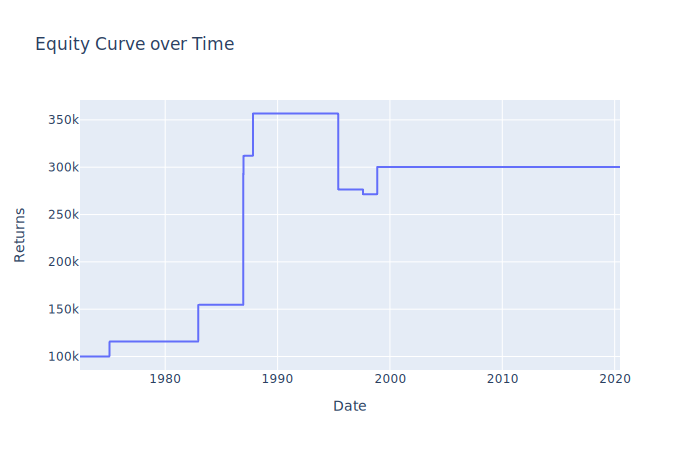

In [335]:
fig = px.line(equity_curve, x=equity_curve.index, y="Returns", title='Equity Curve over Time')
fig.show()

Interestingly, there have been no trades since 1999, and the pairs trading actually lost money in 1995. We also overfit to this model as we choose our regression coefficients based on the entire dataset. A more accurate approach to this problem would be based on a rolling window value.

## Rolling Window

We will try three rolling values: 30, 60, 90.

In [336]:
# Initiate models.
model_30, model_60, model_90 = StatArb(), StatArb(), StatArb()

In [337]:
model_30.allocate(data['KO'], data['PEP'], window=30)
model_60.allocate(data['KO'], data['PEP'], window=60)
model_90.allocate(data['KO'], data['PEP'], window=90)

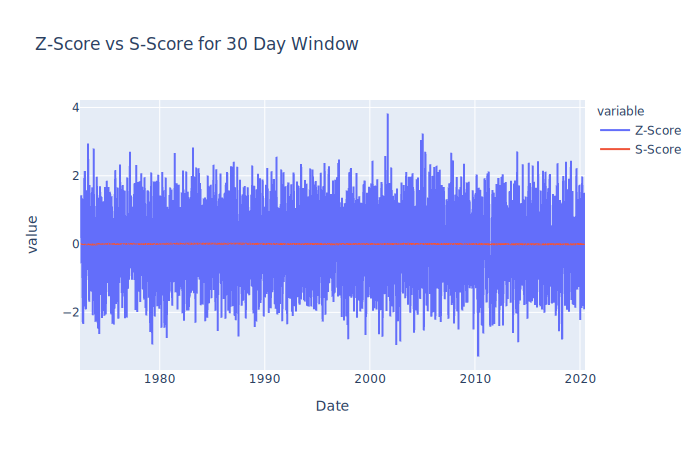

In [339]:
z_s_score = pd.concat([model_30.z_score, model_30.s_score], axis=1)
fig = px.line(z_s_score, x=model_30.cum_resid.index, y=z_s_score.columns, title='Z-Score vs S-Score for 30 Day Window')
fig.show()

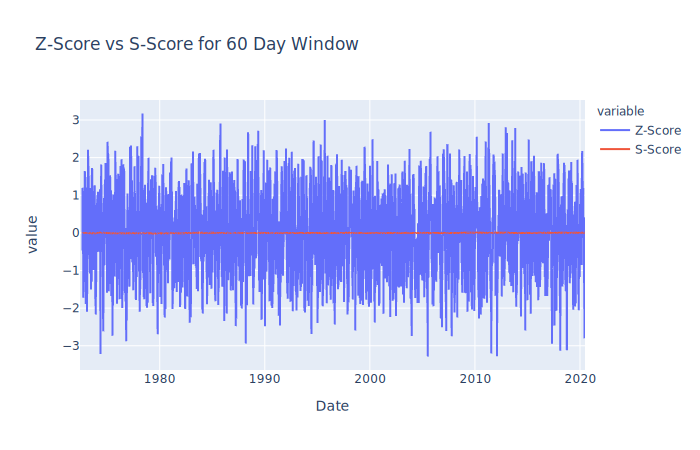

In [340]:
z_s_score = pd.concat([model_60.z_score, model_60.s_score], axis=1)
fig = px.line(z_s_score, x=model_60.cum_resid.index, y=z_s_score.columns, title='Z-Score vs S-Score for 60 Day Window')
fig.show()

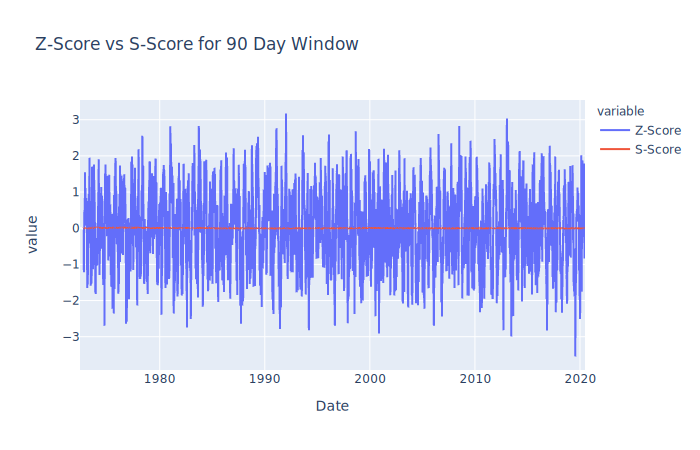

In [341]:
z_s_score = pd.concat([model_90.z_score, model_90.s_score], axis=1)
fig = px.line(z_s_score, x=model_90.cum_resid.index, y=z_s_score.columns, title='Z-Score vs S-Score for 90 Day Window')
fig.show()

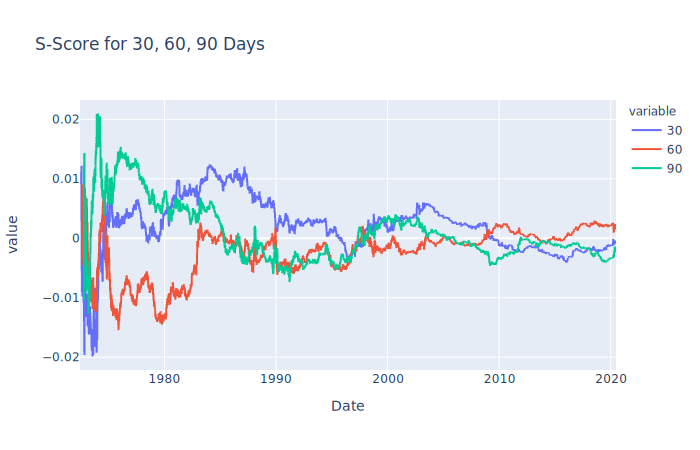

In [352]:
all_s_score = pd.concat([model_30.s_score, model_60.s_score, model_90.s_score], axis=1)
all_s_score.columns=[30, 60, 90]
fig = px.line(all_s_score, x=all_s_score.index, y=all_s_score.columns, title='S-Score for 30, 60, 90 Days')
fig.show()

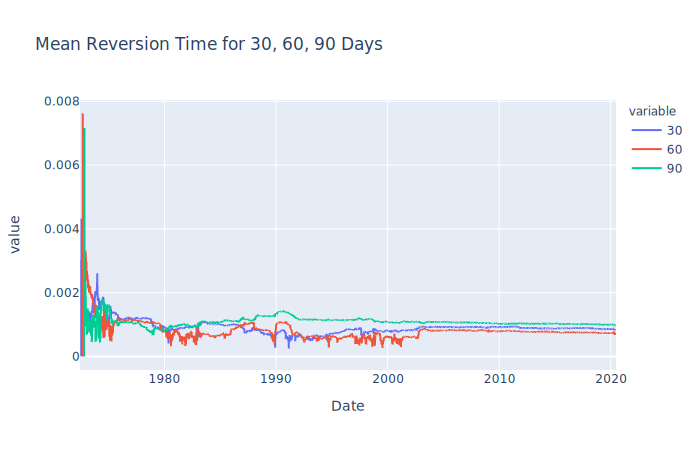

In [353]:
all_mr_time = pd.concat([model_30.mr_time, model_60.mr_time, model_90.mr_time], axis=1)
all_mr_time.columns=[30, 60, 90]
fig = px.line(all_mr_time, x=all_mr_time.index, y=all_mr_time.columns, title='Mean Reversion Time for 30, 60, 90 Days')
fig.show()

There might be more sophisticated methods of trading based on the s-score and mean reversion time, but for now, we will focus on the z-scores.

### 30 Days

In [384]:
enter_short_x_30, exit_short_x_30, enter_long_x_30, exit_long_x_30 = identify_signal_points(2, 1, model_30.z_score)

In [385]:
enter_pos_30, exit_pos_30 = union_pos(enter_short_x_30, exit_short_x_30, enter_long_x_30, exit_long_x_30)

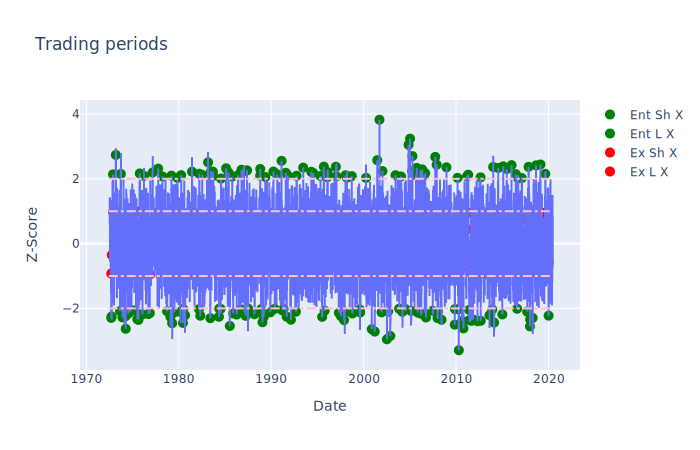

In [359]:
graph_signal_points(2, 1, enter_short_x_30, exit_short_x_30, enter_long_x_30, exit_long_x_30, model_30.z_score)

This is a lot more trades than before. The closing positions are covered by the oscillation.

In [409]:
capital_list_30 = calc_trade_returns(model_30, 100000, enter_short_x_30, exit_short_x_30, enter_long_x_30, exit_long_x_30)

In [410]:
equity_curve_30 = calc_equity_curve(model_30.z_score, capital_list_30, exit_pos_30)

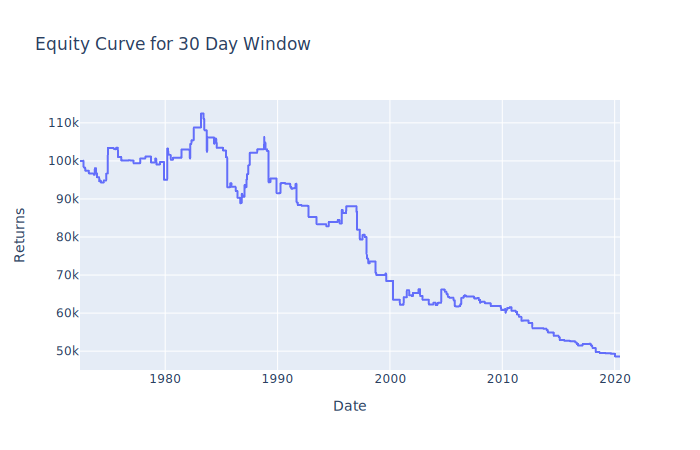

In [411]:
fig = px.line(equity_curve_30, x=equity_curve_30.index, y="Returns", title='Equity Curve for 30 Day Window')
fig.show()

30 Day rolling window failed to perform well and consistently lost value.

### 60 Days

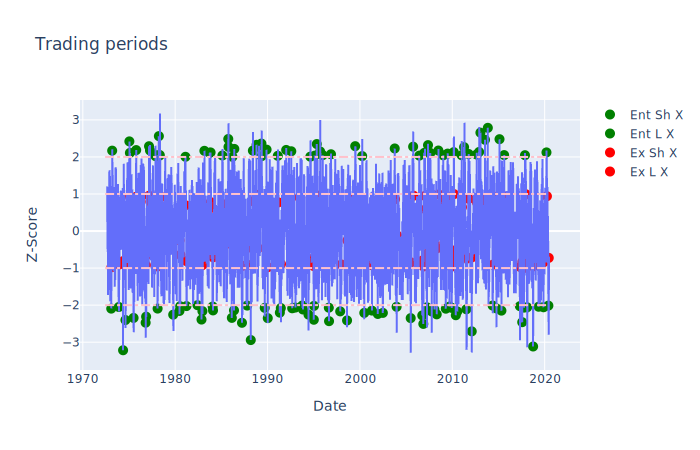

In [412]:
enter_short_x_60, exit_short_x_60, enter_long_x_60, exit_long_x_60 = identify_signal_points(2, 1, model_60.z_score)
enter_pos_60, exit_pos_60 = union_pos(enter_short_x_60, exit_short_x_60, enter_long_x_60, exit_long_x_60)
graph_signal_points(2, 1, enter_short_x_60, exit_short_x_60, enter_long_x_60, exit_long_x_60, model_60.z_score)

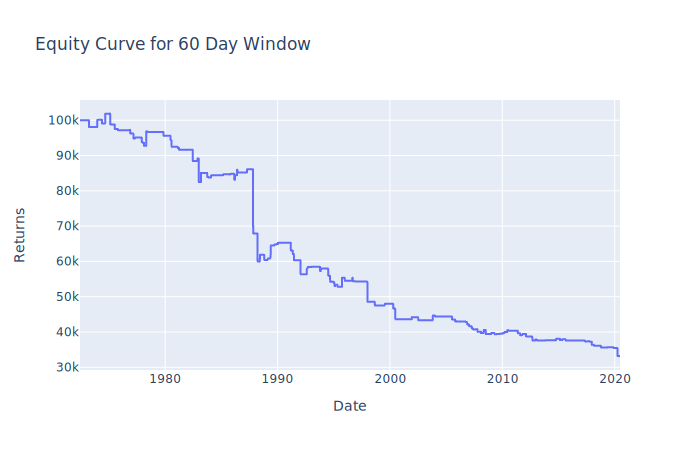

In [413]:
capital_list_60 = calc_trade_returns(model_60, 100000, enter_short_x_60, exit_short_x_60, enter_long_x_60, exit_long_x_60)
equity_curve_60 = calc_equity_curve(model_60.z_score, capital_list_60, exit_pos_60)
fig = px.line(equity_curve_60, x=equity_curve_60.index, y="Returns", title='Equity Curve for 60 Day Window')
fig.show()

60 Day rolling window performs even worse than the 30 day one.

### 90 Days

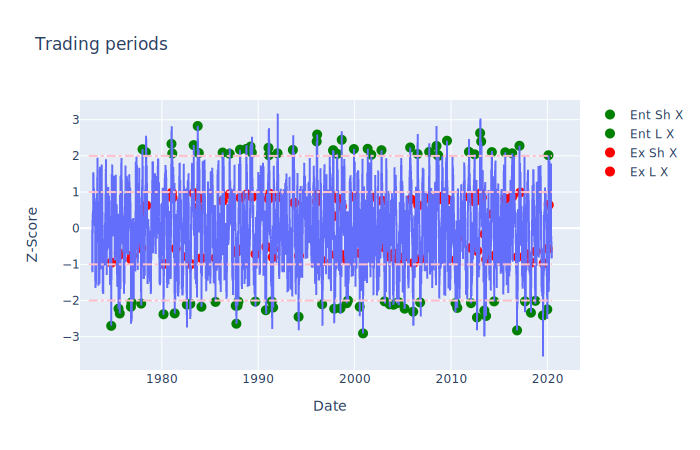

In [414]:
enter_short_x_90, exit_short_x_90, enter_long_x_90, exit_long_x_90 = identify_signal_points(2, 1, model_90.z_score)
enter_pos_90, exit_pos_90 = union_pos(enter_short_x_90, exit_short_x_90, enter_long_x_90, exit_long_x_90)
graph_signal_points(2, 1, enter_short_x_90, exit_short_x_90, enter_long_x_90, exit_long_x_90, model_90.z_score)

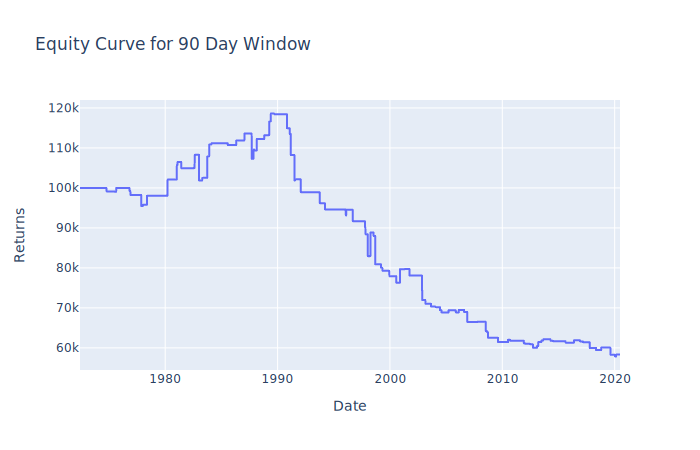

In [415]:
capital_list_90 = calc_trade_returns(model_90, 100000, enter_short_x_90, exit_short_x_90, enter_long_x_90, exit_long_x_90)
equity_curve_90 = calc_equity_curve(model_90.z_score, capital_list_90, exit_pos_90)
fig = px.line(equity_curve_90, x=equity_curve_90.index, y="Returns", title='Equity Curve for 90 Day Window')
fig.show()

The results were slightly better for 90 days, but the strategy failed after 1990.